In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform, kstest

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

Create a distribution, and sample from it twice

In [2]:
class TimeSeriesModel:
    def __init__(self, a = 0., sigma=1., nt=100):
        self.t = np.linspace(0, 10, nt)
        self.a = a
        self.sigma = sigma
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        y = self.a * np.cos(self.t) + self.sigma * np.random.randn(num_samples, len(self.t))
        return y


In [3]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
chisqs_mean = np.zeros_like(amps)
chisqs_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    zs = []
    dof_array = []
    for _ in range(num_repeats):
        z, dof = pqm_chi2(y_samples, null_samples)
        zs.append(z)
        dof_array.append(dof)
        
    chisqs_mean[i] = np.mean(zs)
    chisqs_std[i] = np.std(zs)
    print(a, chisqs_mean[i], chisqs_std[i], np.unique(dof_array))

0.01 99.50622982343907 14.318511066532395 [95 96 97 98 99]
0.012742749857031334 97.40345006389876 13.395341497195984 [95 96 97 98 99]
0.016237767391887217 99.19841968061361 10.962814859399312 [95 96 97 98 99]
0.0206913808111479 104.78565915909073 10.836487341279218 [95 97 98 99]
0.026366508987303583 102.93810091612292 10.877068649398936 [94 95 96 97 98 99]
0.03359818286283781 107.84707957416666 11.073347628122235 [94 96 97 98 99]
0.04281332398719394 109.47067094447398 15.017359896747699 [94 95 96 97 98 99]
0.0545559478116852 116.21788383407491 17.21517040370091 [93 94 95 96 97 98 99]
0.06951927961775606 124.64086394073865 16.85265568709065 [94 95 96 97 98 99]
0.08858667904100823 149.48388914113474 22.660404321703144 [96 97 98 99]
0.11288378916846889 170.76158295673775 27.184511808017387 [94 96 97 98 99]
0.14384498882876628 235.65559753936623 35.5220786678198 [89 92 95 96 97 98 99]
0.18329807108324356 298.3467066185834 41.06149830131648 [93 95 96 97 98 99]
0.23357214690901212 450.530576

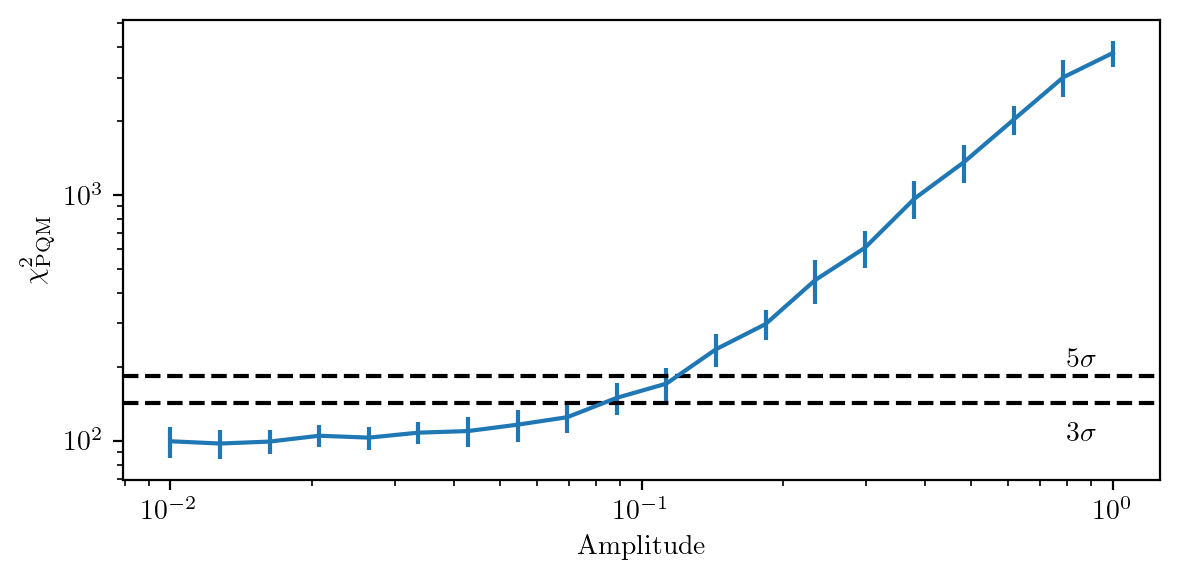

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(amps, chisqs_mean, yerr=chisqs_std)
ax.axhline(chi2.ppf(0.997300203936740, 99), ls='--', color='k')
ax.axhline(chi2.ppf(0.999999426696856, 99), ls='--', color='k')
ax.text(0.8, 100, r'$3 \sigma$')
ax.text(0.8, 200, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('$\chi^2_{\mathrm{ PQM}}$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

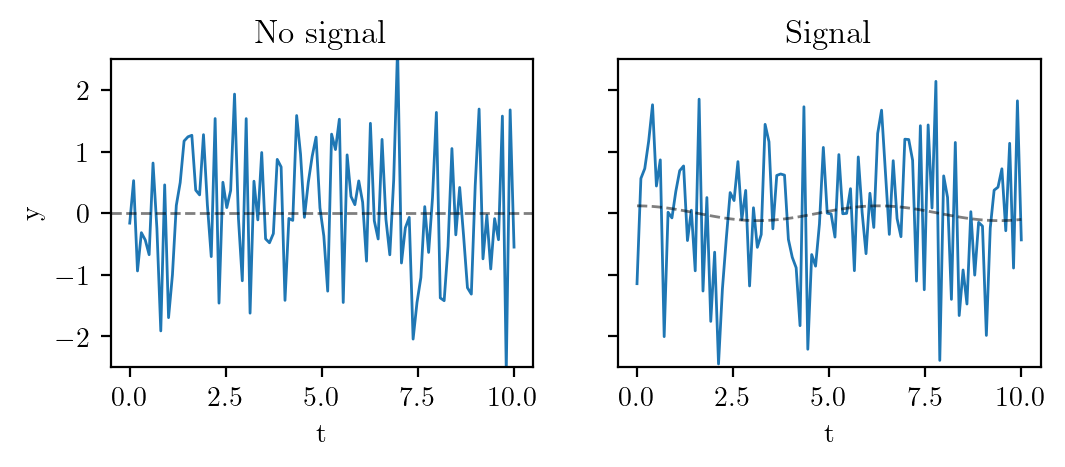

In [5]:
gmm = TimeSeriesModel(a = 0.12)
gmm_null = TimeSeriesModel(a = 0)
x_samples = gmm.generate_samples(num_samples=2)
null_samples = gmm_null.generate_samples(num_samples=2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 2), sharex=True, sharey=True)
axs[0].plot(gmm.t, null_samples[0], lw=1)
axs[0].axhline(0, color='k', lw=1, ls='--', alpha=0.5)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel('t')
axs[0].set_ylabel('y')
axs[0].set_title('No signal')

axs[1].plot(gmm.t, x_samples[0], lw=1)
axs[1].plot(gmm.t, gmm.a * np.cos(gmm.t), color='k', lw=1, ls='--', alpha=0.5)
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_title('Signal')
axs[1].set_xlabel('t')

plt.show()

# Using p-value

In [6]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
p_val_mean = np.zeros_like(amps)
p_val_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    p_val = []
    for _ in range(num_repeats):
        pval = pqm_pvalue(y_samples, null_samples)
        p_val.append(pval)
    if np.abs(np.mean(p_val) - 0.5) < 0.15:
        print("Do not reject the null hypothesis")
    else:
        print("Reject the null hypothesis")
    p_val_mean[i] = np.mean(p_val)
    p_val_std[i] = np.std(p_val)
    print(a, np.mean(p_val), np.std(p_val))

Do not reject the null hypothesis
0.01 0.36028607242192606 0.25274703936583226
Do not reject the null hypothesis
0.012742749857031334 0.42124112720325313 0.2434686460388023
Do not reject the null hypothesis
0.016237767391887217 0.494283197176639 0.2800523381167084
Do not reject the null hypothesis
0.0206913808111479 0.41413165032706367 0.286561550807819
Do not reject the null hypothesis
0.026366508987303583 0.41669953082815037 0.29275504235277494
Reject the null hypothesis
0.03359818286283781 0.20632561490085338 0.21474735289900485
Do not reject the null hypothesis
0.04281332398719394 0.3984963560012865 0.2685561668037286
Reject the null hypothesis
0.0545559478116852 0.2748750240488624 0.23563301358898103
Reject the null hypothesis
0.06951927961775606 0.09077555272284035 0.10913140898917104
Reject the null hypothesis
0.08858667904100823 0.01778346163698786 0.021364356772423713
Reject the null hypothesis
0.11288378916846889 0.00011230929405883876 0.00030837524979351487
Reject the null h

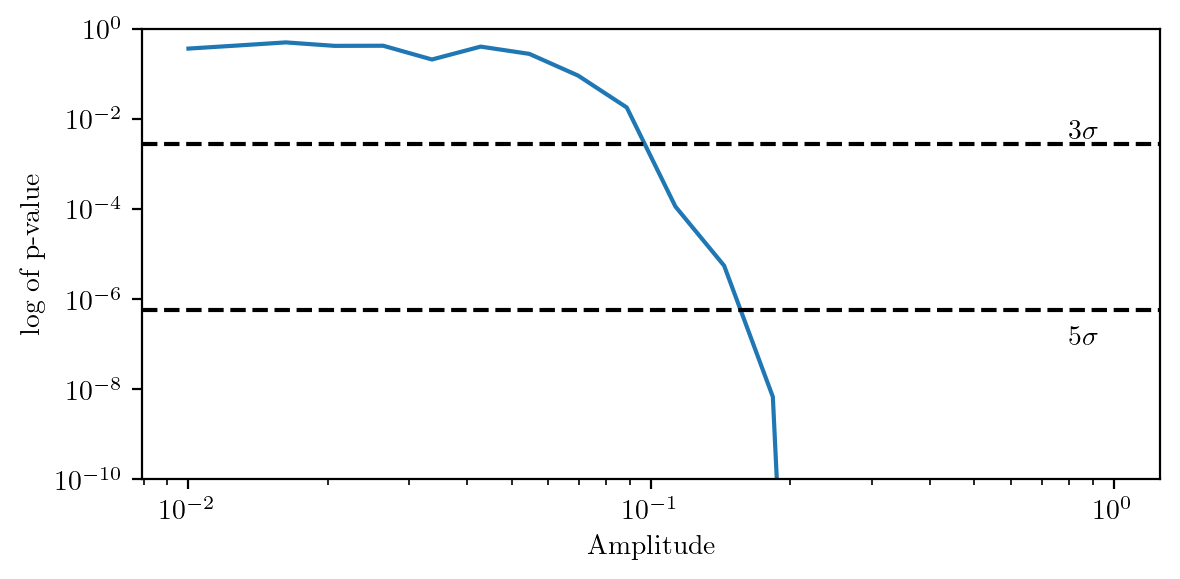

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(amps, p_val_mean)
ax.axhline(1 - 0.997300203936740, ls='--', color='k')  # 3 sigma equivalent p-value
ax.axhline(1 - 0.999999426696856, ls='--', color='k')  # 5 sigma equivalent p-value
ax.text(0.8, 0.01, r'$3 \sigma$', verticalalignment='top')
ax.text(0.8, 0.0000001, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('log of p-value')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()
